In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from utils import Normalise
from dataset import HDF5Sequence, ConcatSequence
import fk
import matplotlib.pyplot as plt
import numpy as np
import random
from utils import space_grad, space_grad_mse_loss
from unet3d import Unet3D
from resnet import ResNet
from glob import glob
import time
from IPython.display import Video

In [17]:
# model = ResNet.load_from_checkpoint(glob("logs/resnet/lightning_logs/version_3/checkpoints/*.ckpt")[0])
model = ResNet.load_from_checkpoint(glob("logs/lightning_logs/version_5/checkpoints/last.ckpt")[0],
                                    root="/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/",
                                    paramset="3",
                                    batch_size=2,
                                    n_workers=0,
                                    frames_out=200)

print("Model contains {:,} parameters".format(model.parameters_count()))
filename = "/media/ep119/DATADRIVE3/epignatelli/deepexcite/test_set/fig7.hdf5"
fkset = HDF5Sequence(filename, model.frames_in, model.frames_out, model.step, transform=Normalise())

Model contains 140,305 parameters


In [18]:
# get data
device = torch.device("cuda:1")
sequence = torch.as_tensor(fkset[0])

# to gpu
model = model.to(device)
sequence = sequence.to(device)

# format data
x = sequence[:model.frames_in]
y = sequence[model.frames_in:]

# infer
start = time.time()
pred = model.infer(x)
elapsed = time.time() - start
print(pred.shape)

print("Computation time: {:.6f}ms".format(elapsed))
print("Input")

# error
mae = torch.nn.functional.l1_loss(pred[:, 2], y[:, 2].cpu(), reduction="none")

torch.Size([200, 3, 256, 256])
Computation time: 5.311590ms
Input


### Animation

In [ ]:
pred_video = fk.plot.animate_state(fk.convert.u_to_V(y_hat).cpu(), figsize=(20, 5))
Video(data=pred_video.to_html5_video(), embed=True)

In [ ]:
truth_video = fk.plot.animate_state(fk.convert.u_to_V(y).cpu(), figsize=(20, 5))
Video(data=truth_video.to_html5_video(), embed=True)

### Setup plots

In [19]:
# plot
rows = 25
figsize = (100,20)

### Plot u

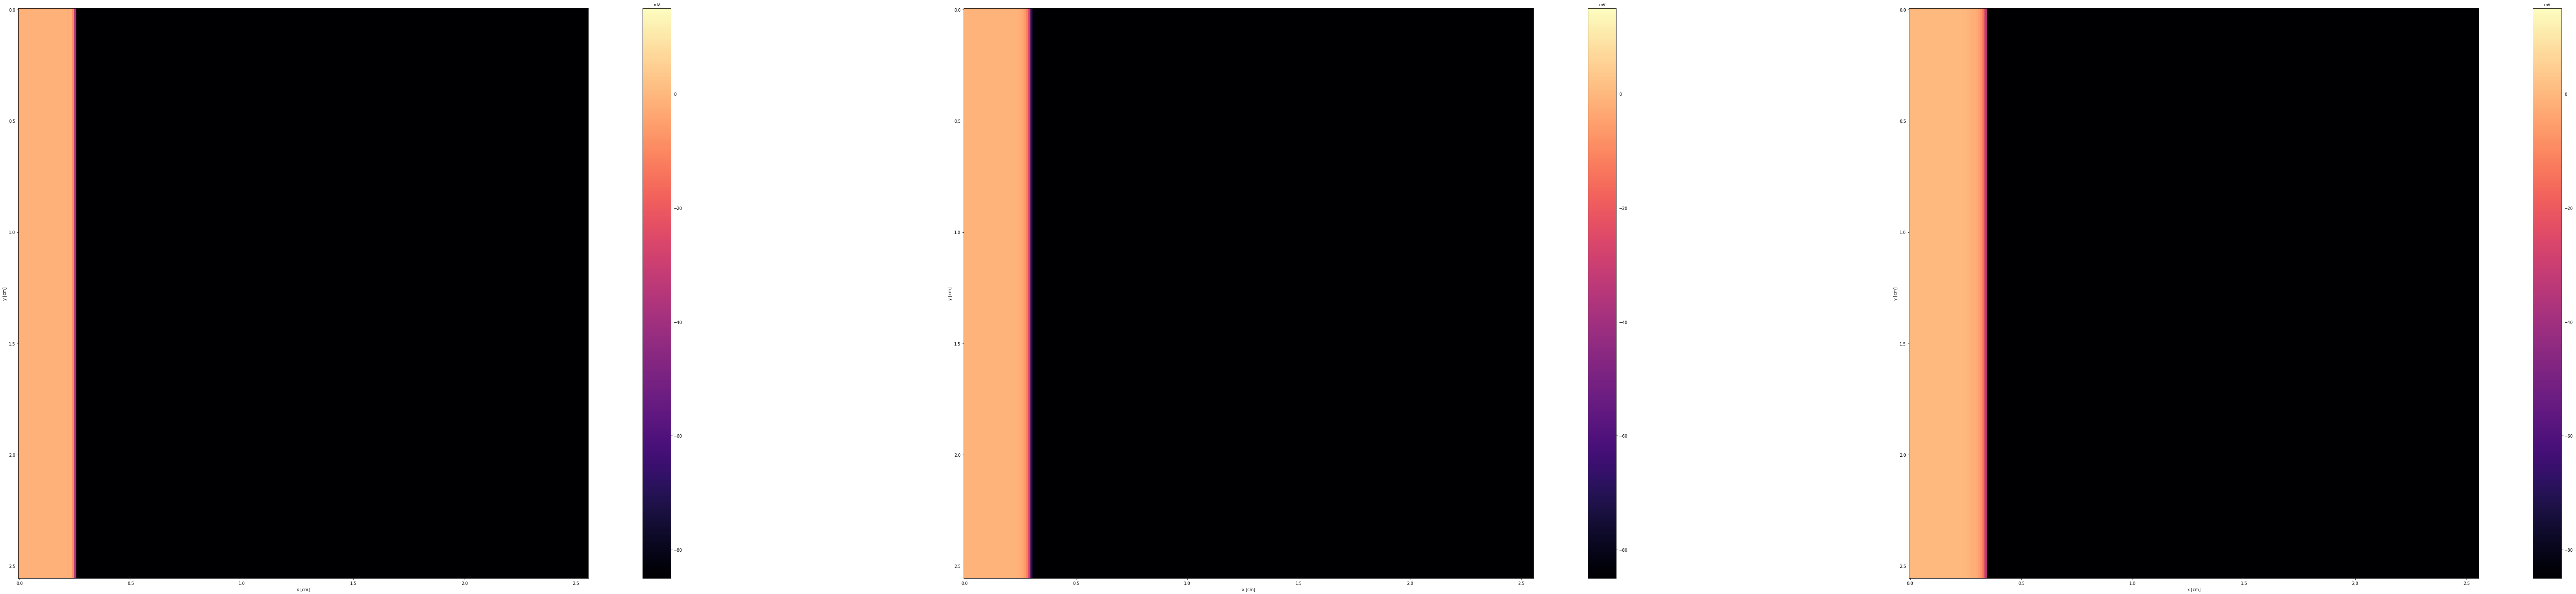

Prediction


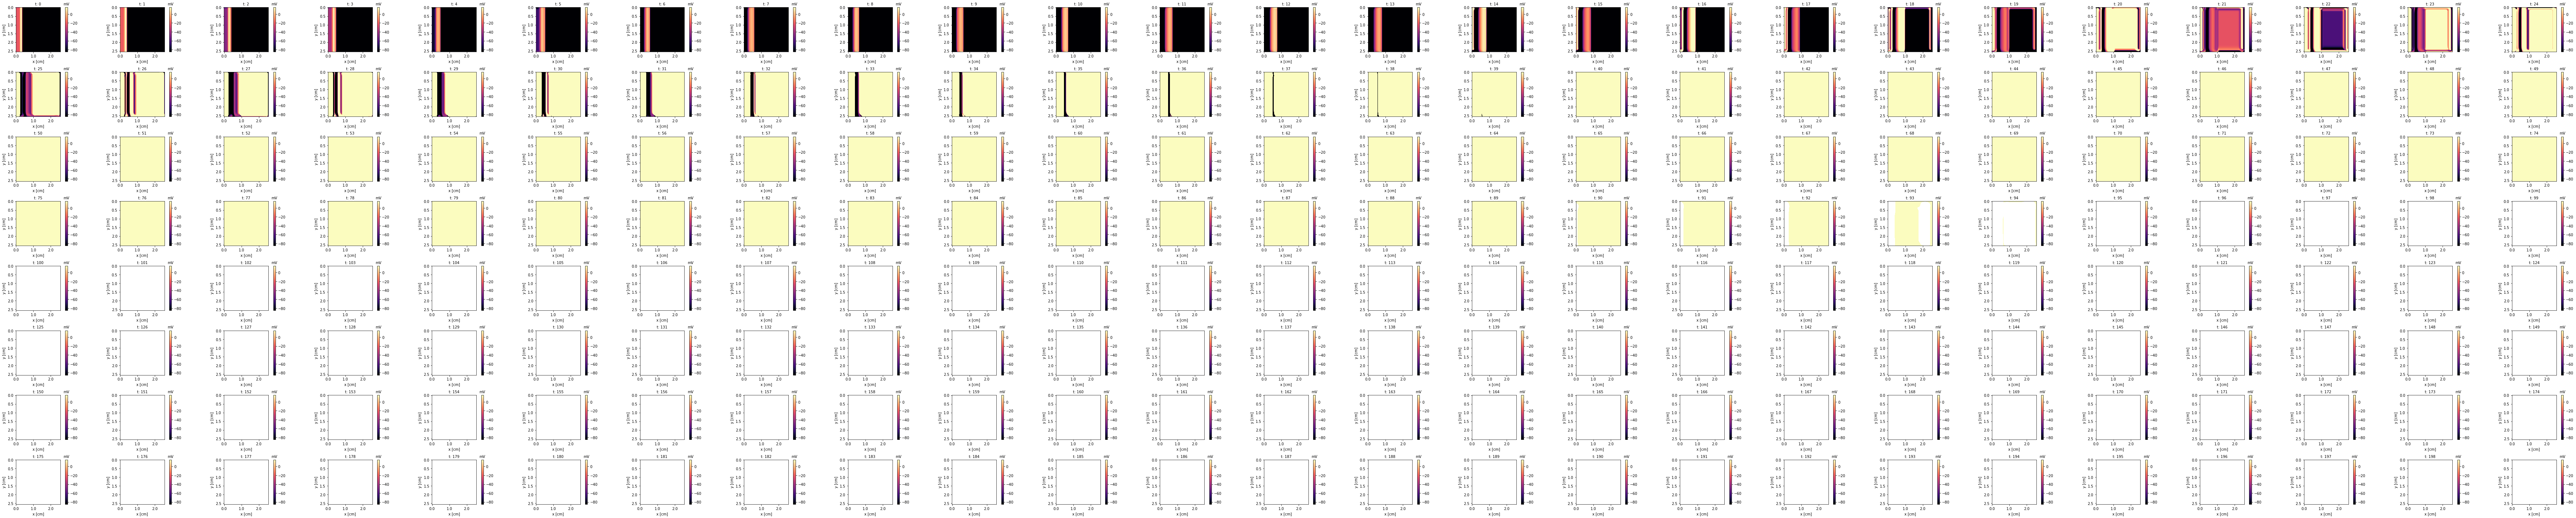

Truth


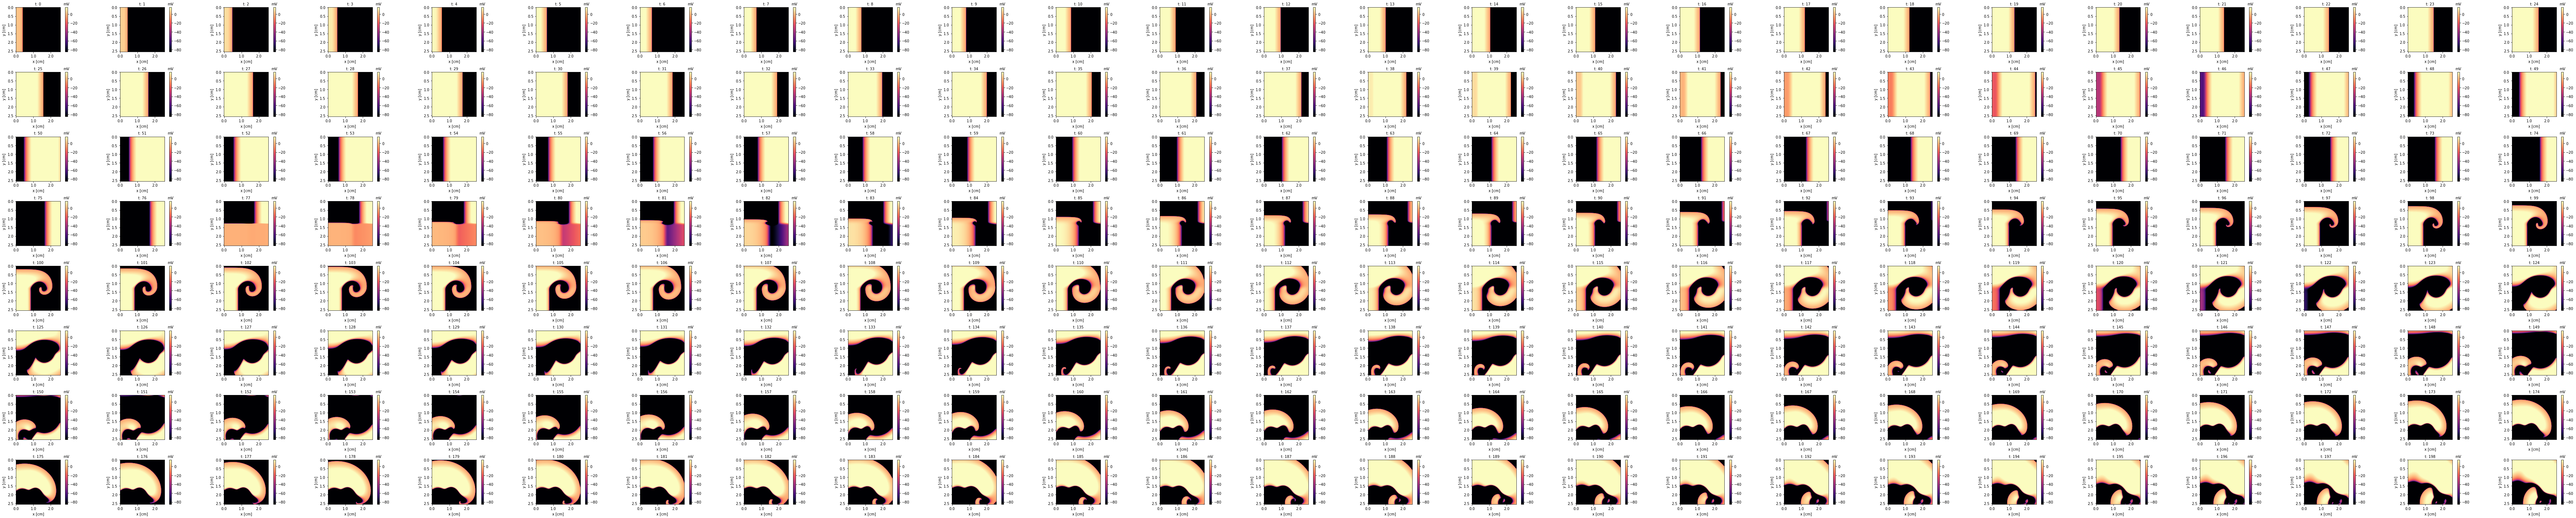

L1 loss


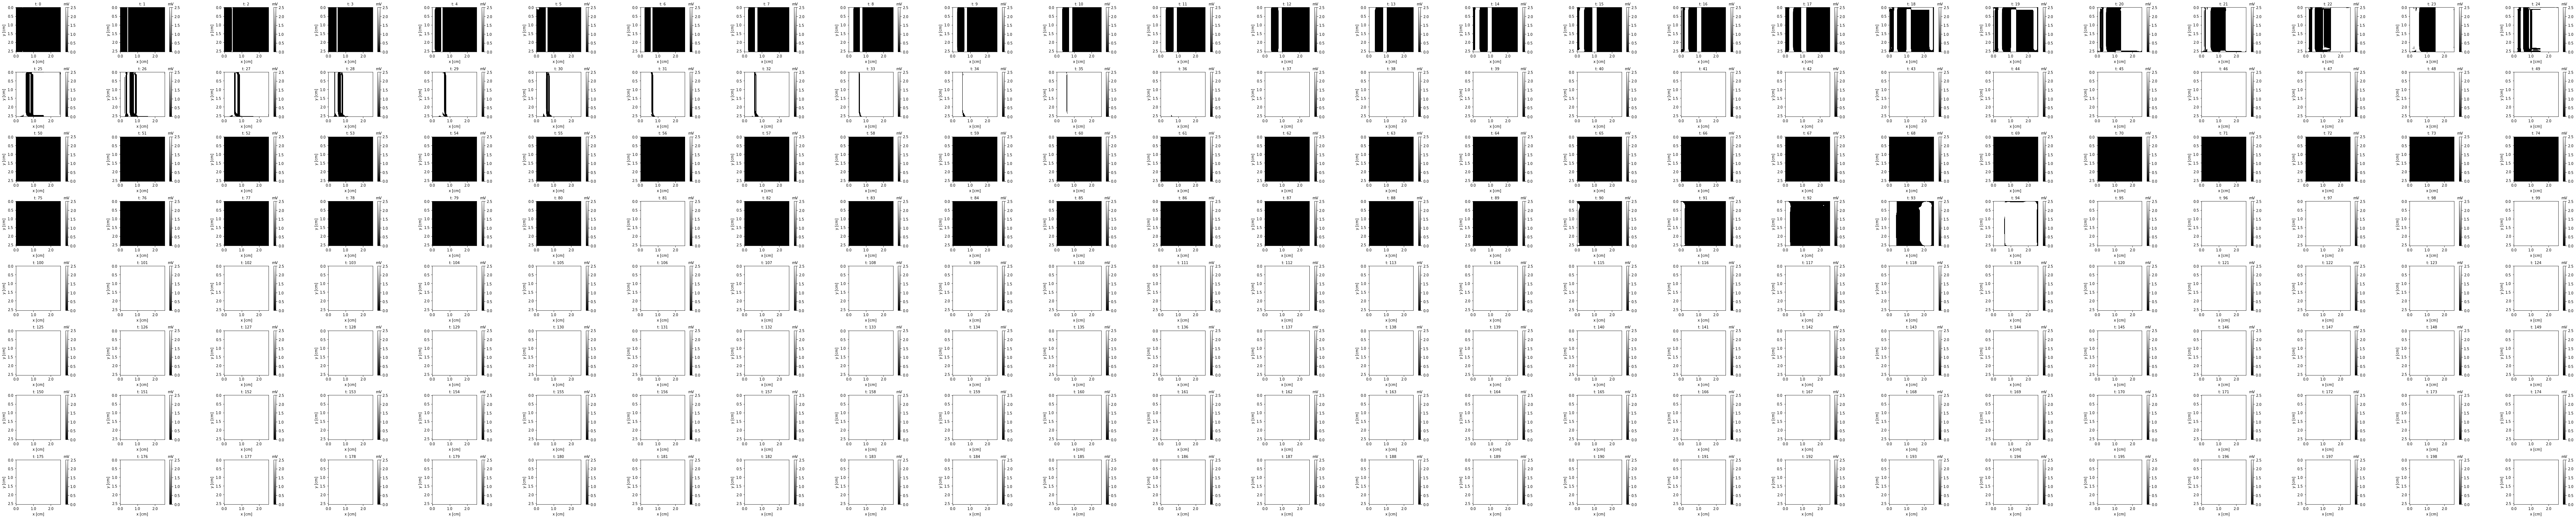

In [20]:
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, 2].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, 2].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("L1 loss")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(mae.detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)), vmin=0, vmax=2.5, cmap="gray")
plt.show()

### Plot w

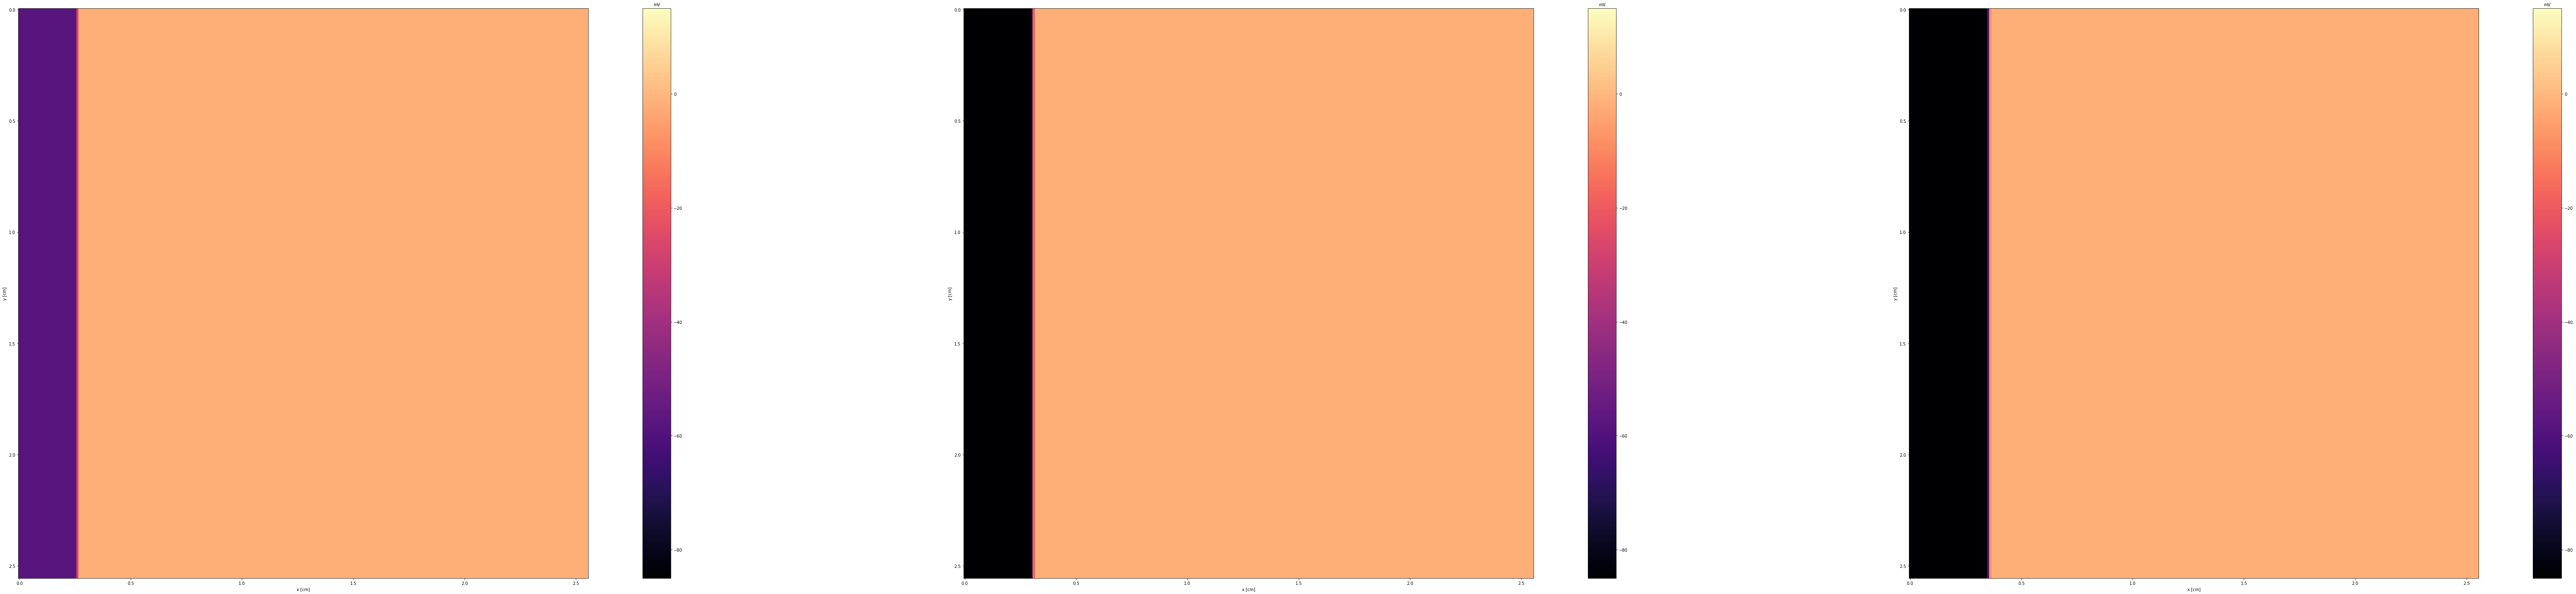

Prediction


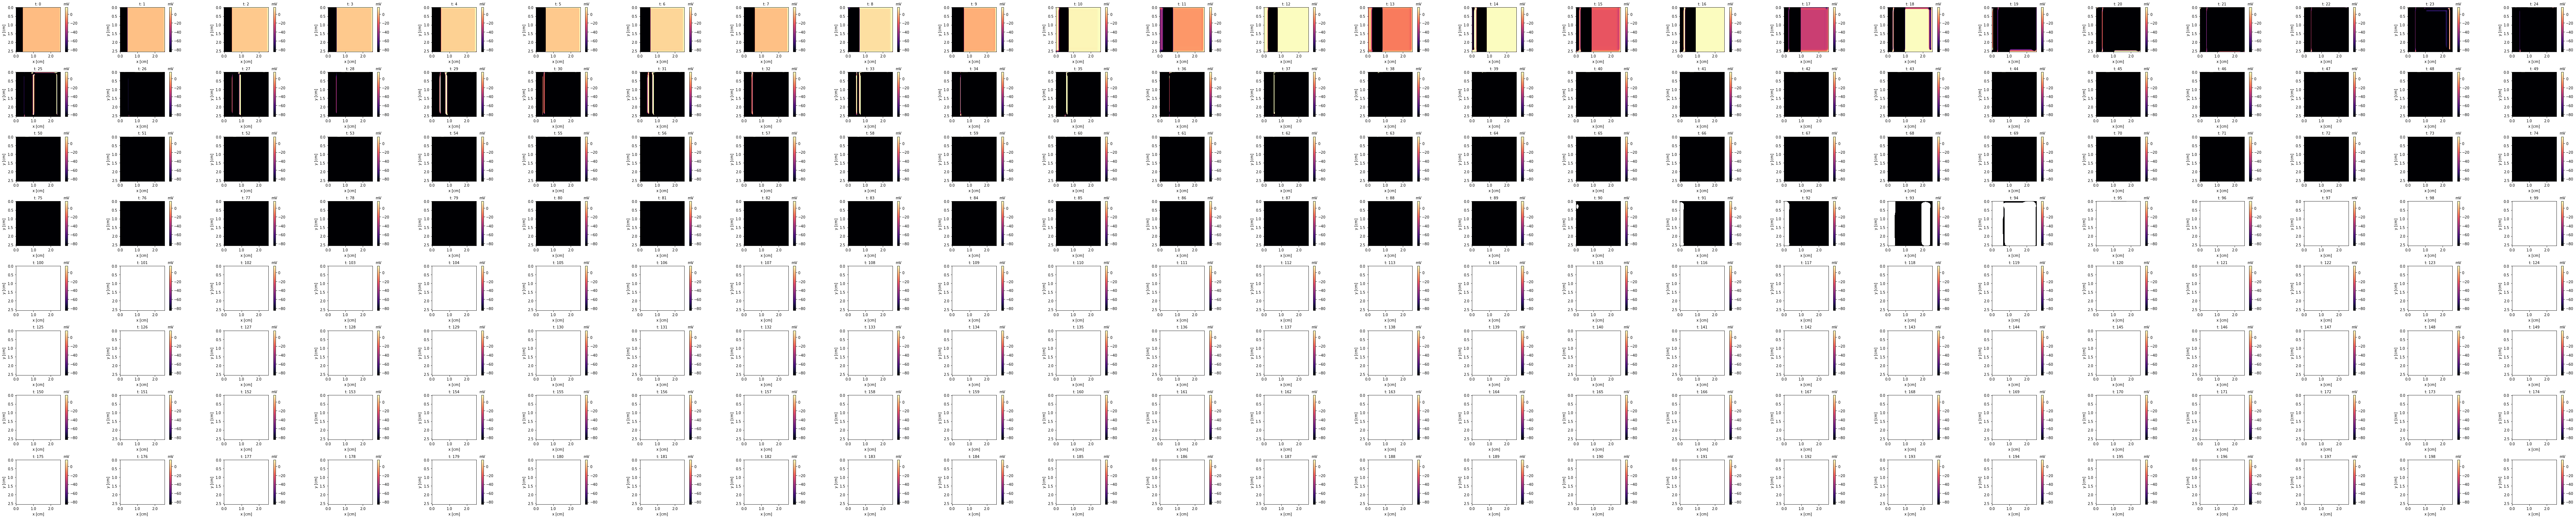

Truth


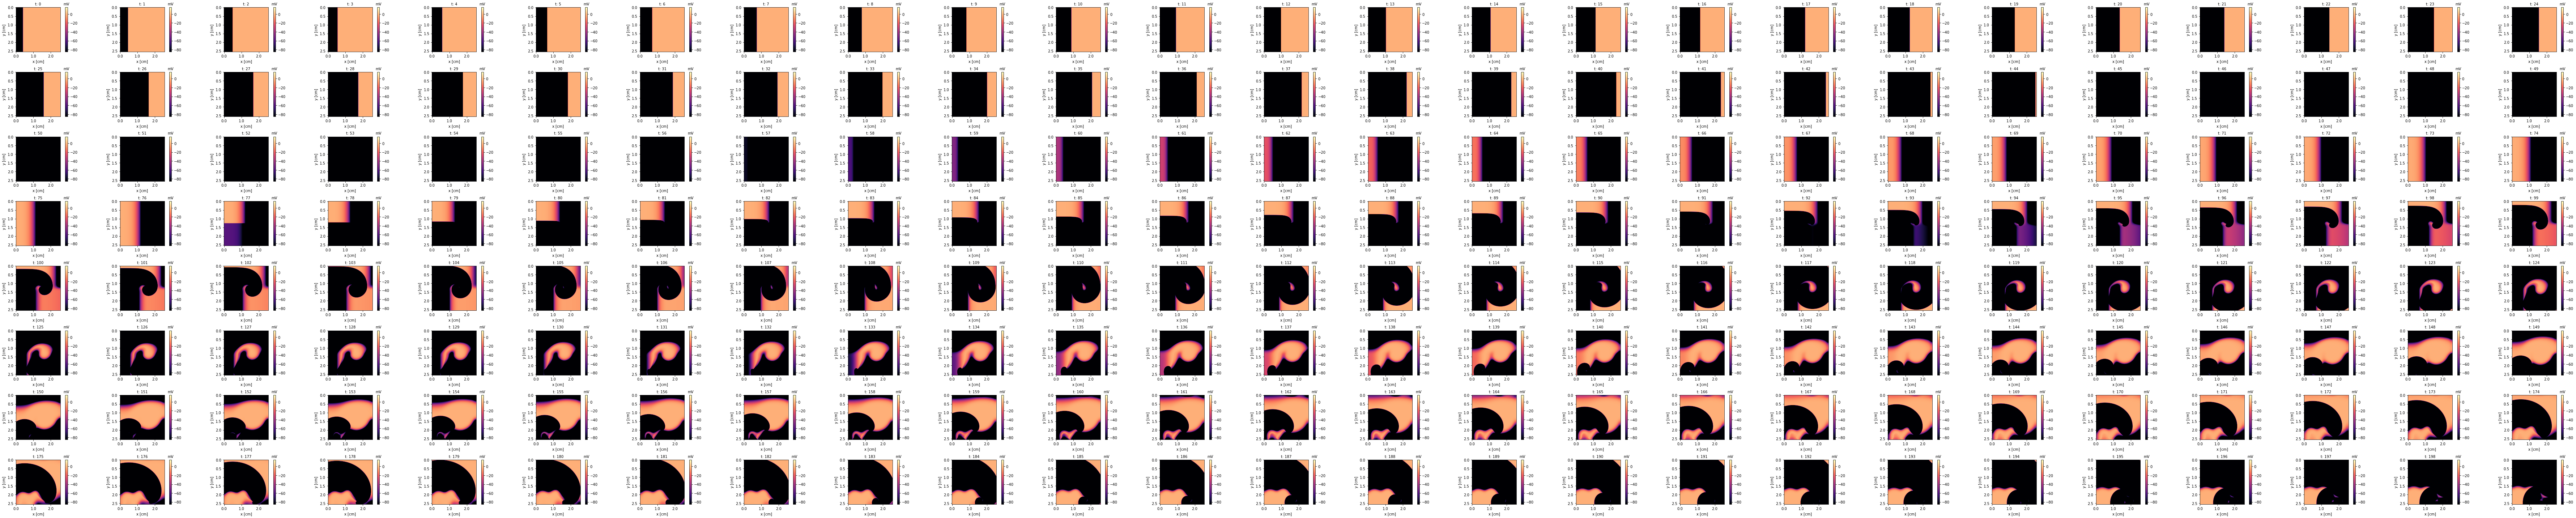

L1 loss


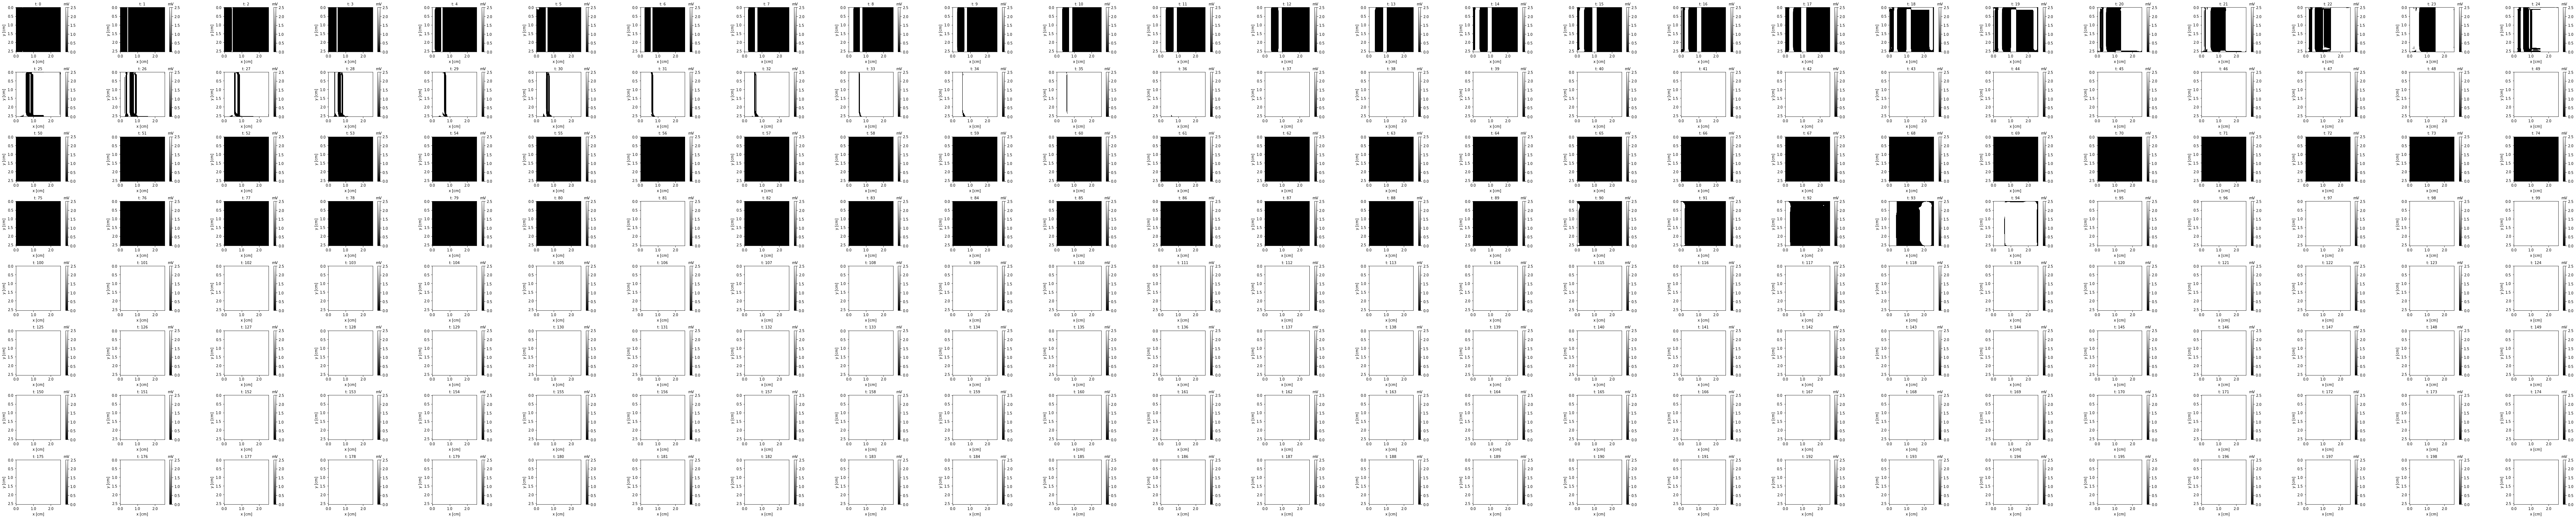

In [21]:
channel = 0
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, channel].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, channel].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, channel].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("L1 loss")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(mae.detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)), vmin=0, vmax=2.5, cmap="gray")
plt.show()

### Plot v

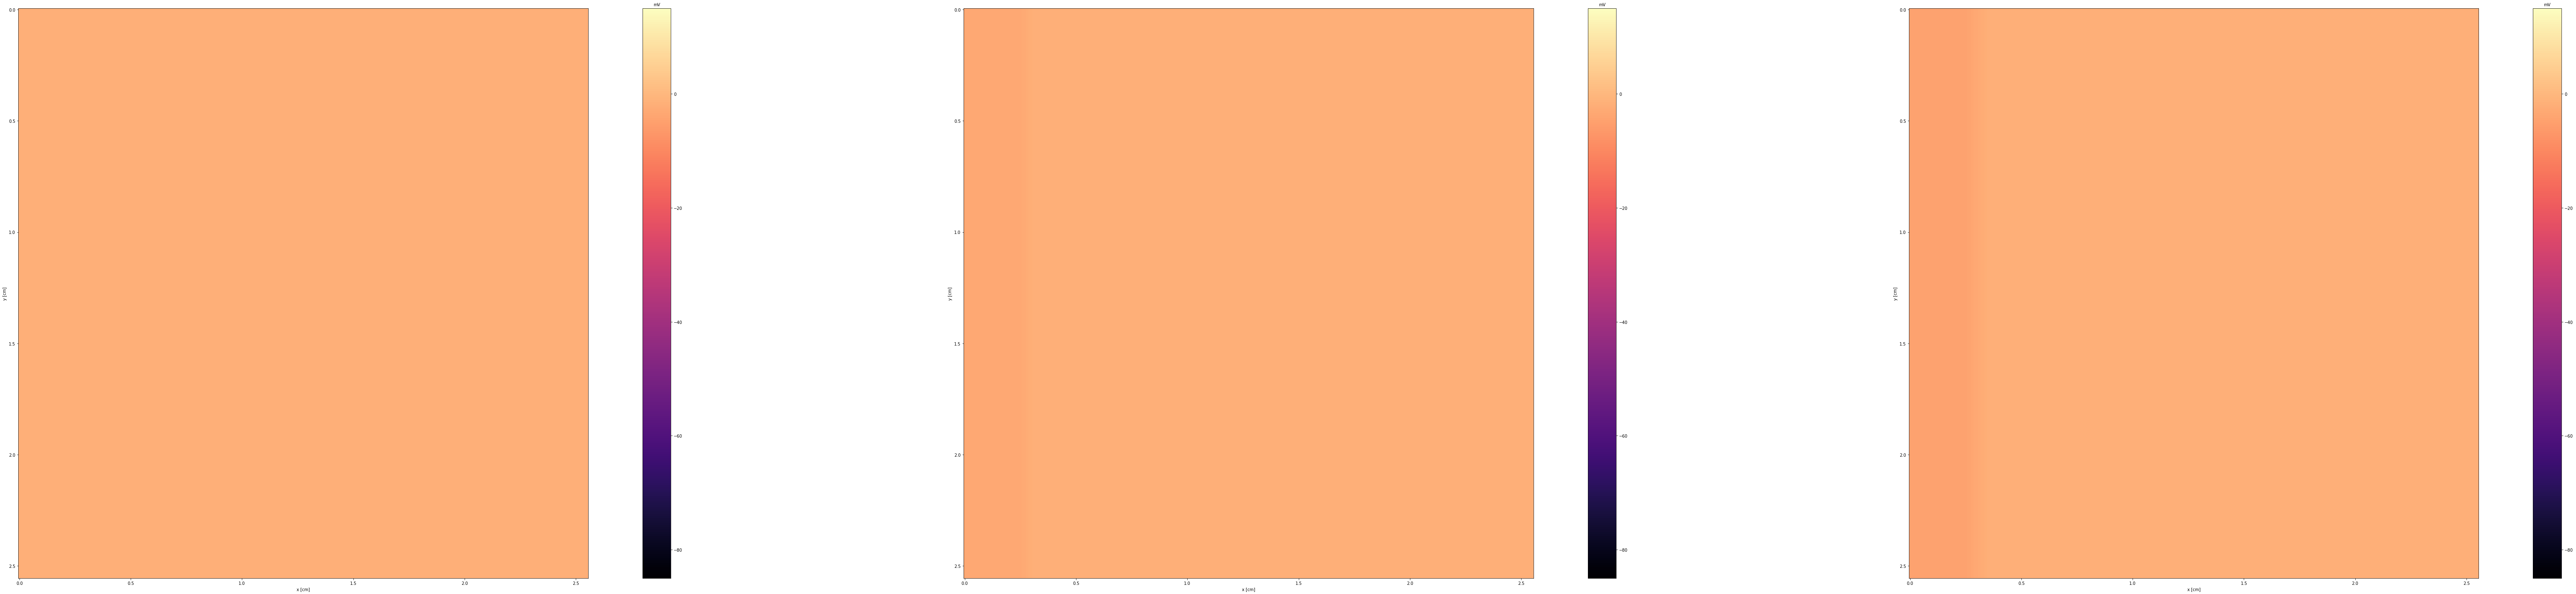

Prediction


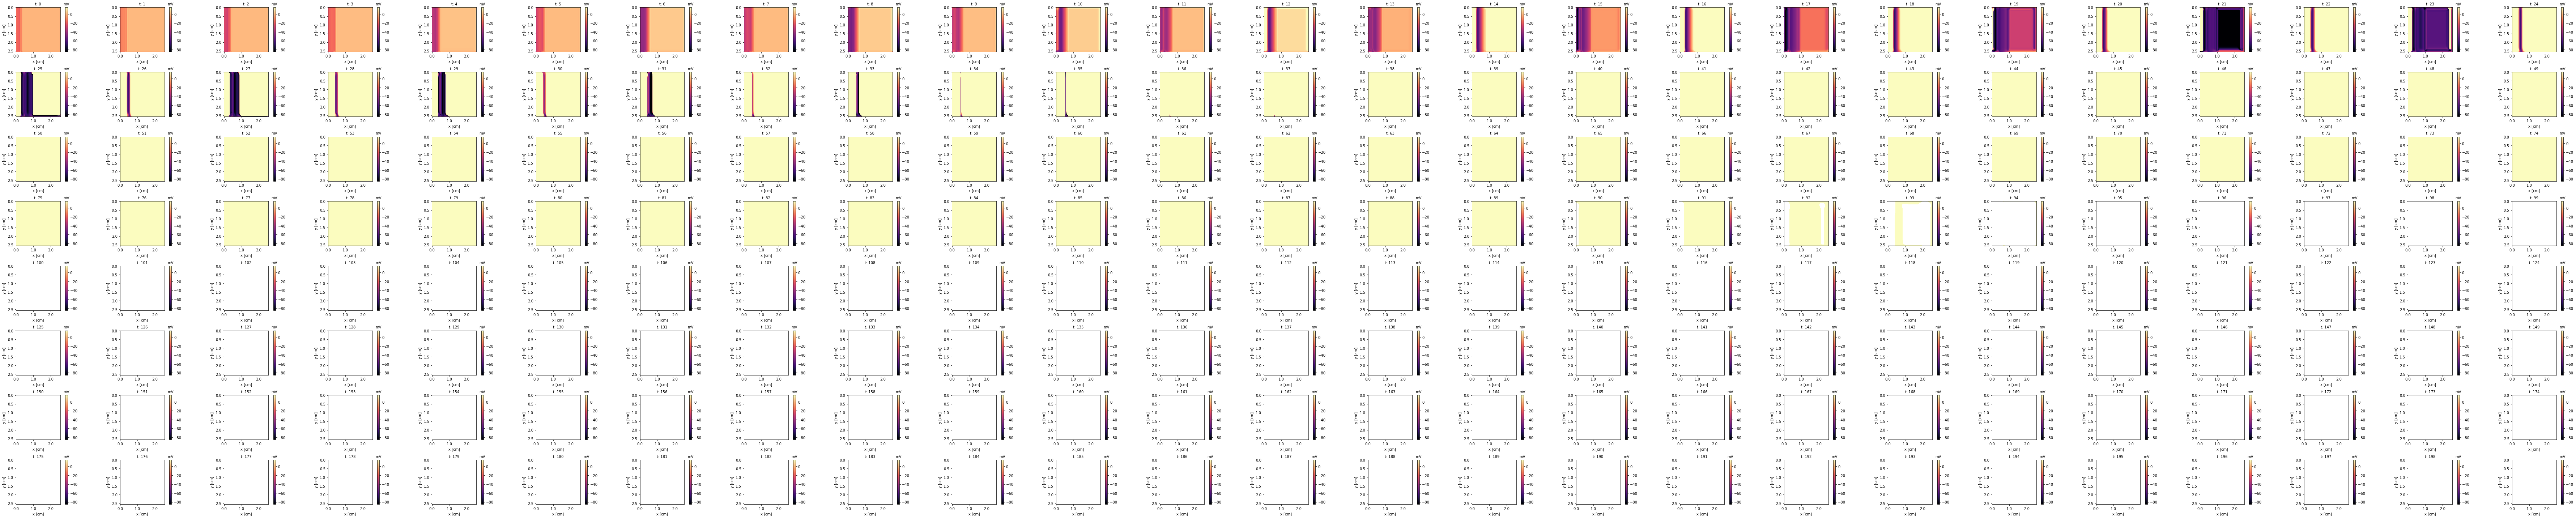

Truth


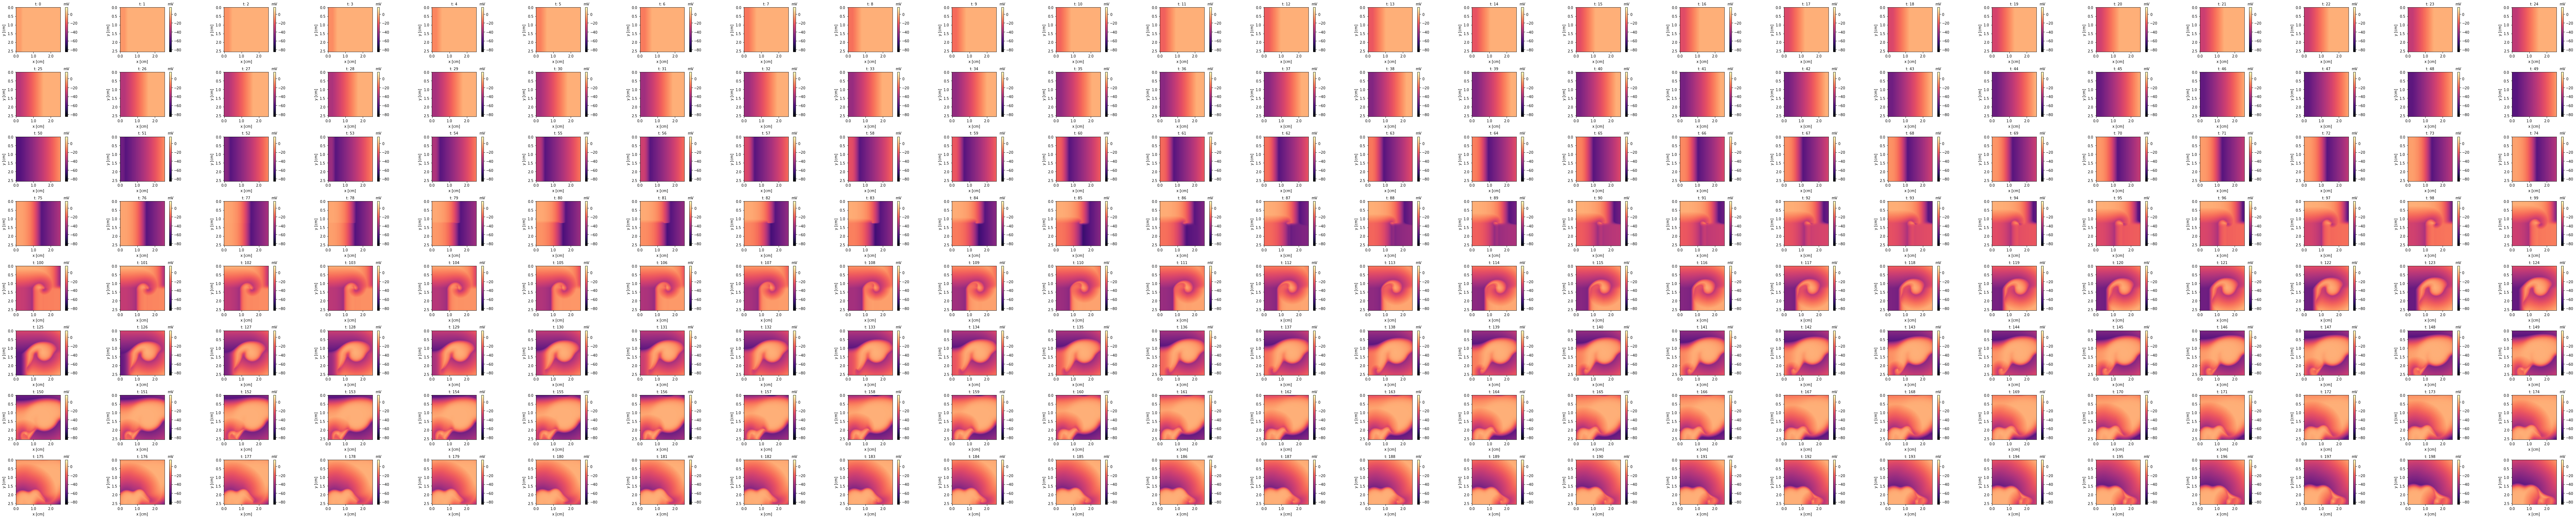

L1 loss


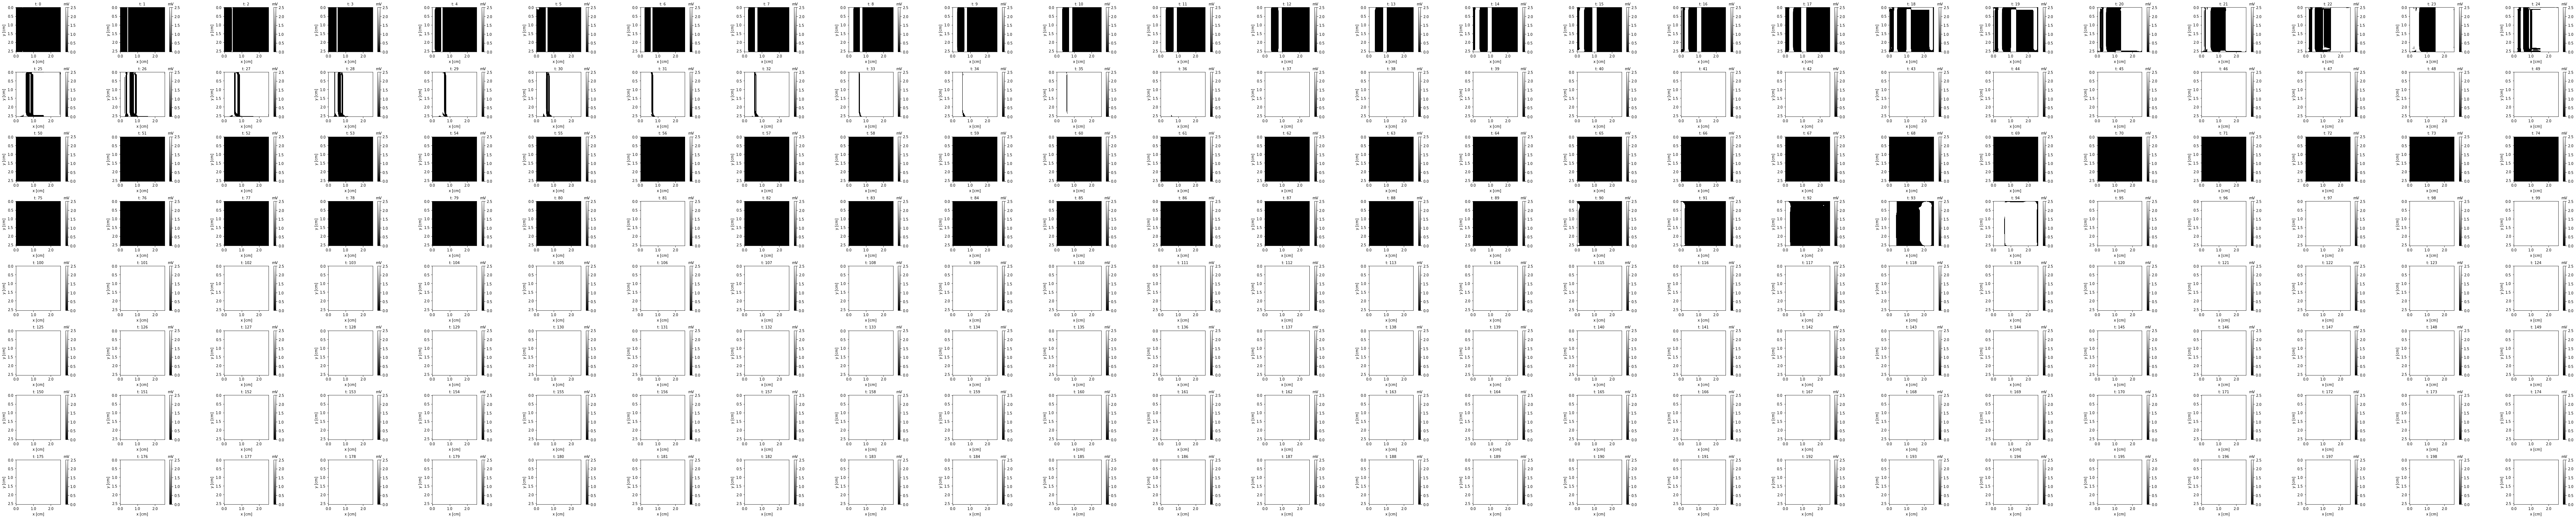

In [22]:
channel = 1
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(x[:, channel].detach().cpu()), rows=rows, figsize=figsize)
plt.show()
print("Prediction")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(pred[:, channel].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("Truth")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(y[:, channel].detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)))
plt.show()
print("L1 loss")
fig, ax = fk.plot.show_grid(fk.convert.u_to_V(mae.detach().cpu()), rows=rows, figsize=figsize, times=np.arange(len(y)), vmin=0, vmax=2.5, cmap="gray")
plt.show()

### Plot mae in time

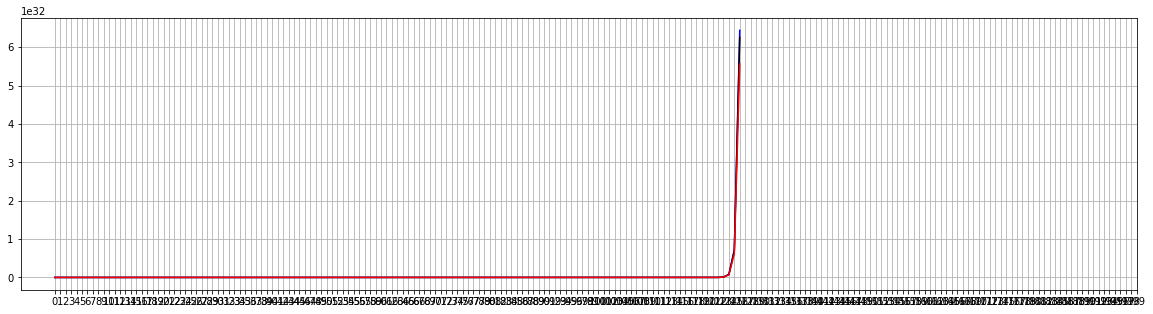

In [16]:
# baselines
mae_zeros = torch.nn.functional.l1_loss(torch.zeros_like(pred), pred, reduction="none")
mae_zeros = [x.mean() for x in mae_zeros]

mae_prev_frame = torch.nn.functional.l1_loss(pred[1:], pred[:-1], reduction="none")
mae_prev_frame = [0.] + [x.mean() for x in mae_prev_frame]

mae_pred = [x.mean() for x in mae]

plt.figure(figsize=(20, 5))
plt.plot(mae_pred, c="blue")
plt.plot(mae_zeros, c="black")
plt.plot(mae_prev_frame, c="red")
plt.grid("on")
plt.xticks(range(len(mae_pred)))
plt.show()

In [2]:
from typing import NamedTuple, Callable, Tuple
from functools import partial
import math
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import jax
from jax import random
from jax.experimental import stax
from jax.experimental import optimizers
from jax.experimental.stax import Conv, Identity, FanInSum, FanOut, Elu
import jax.numpy as jnp
from torch.utils.data import DataLoader
from dataset import MnistDataset, ConcatSequence


class Module(NamedTuple):
    init: Callable[[jnp.ndarray, Tuple], Tuple[Tuple, jnp.ndarray]]
    apply: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray]


def ResidualBlock(out_channels, kernel_size, stride, padding):
    double_conv = stax.serial(
        Conv(out_channels, kernel_size, stride, padding),
        Elu,
        Conv(out_channels, kernel_size, stride, padding),
    )
    return Module(
        *stax.serial(FanOut(2), stax.parallel(double_conv, Identity), FanInSum, Elu)
    )


def ResNet(hidden_channels, out_channels, kernel_size, strides, padding, depth):
    return Module(
        *(
            stax.serial(
                Conv(hidden_channels, kernel_size, strides, padding),
                *[
                    ResidualBlock(hidden_channels, kernel_size, strides, padding)
                    for _ in range(depth)
                ],
                Conv(out_channels, kernel_size, strides, padding)
            )
        )
    )


@partial(jax.jit, static_argnums=0)
def forward(model, params, batch):
    x = y = batch / 255
    y_hat = model.apply(params, x)
    return jnp.mean((y_hat - y) ** 2)


@partial(jax.jit, static_argnums=0)
def backward(model, params, batch):
    return jax.value_and_grad(forward, argnums=1)(model, params, batch)


@partial(jax.jit, static_argnums=(0, 1))
def update(model, optimiser, iteration, optimiser_state, batch):
    params = optimiser.params_fn(optimiser_state)
    loss, gradients = backward(model, params, batch)
    return loss, optimiser.update_fn(iteration, gradients, optimiser_state)


def create_dataloader(root, frames_in, frames_out, step, size, search_regex, preload):
    dataset = ConcatSequence(
        root,
        frames_in,
        frames_out,
        step,
        transform=partial(jax.image.resize, shape=size),
        keys=search_regex,
        preload=preload,
    )
    logging.info(
        "Found training dataset at: {}".format([x.filename for x in dataset.datasets])
    )
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=jnp.stack,
        shuffle=True,
        drop_last=True,
    )
    return train_loader


if __name__ == "__main__":
    from argparse import ArgumentParser

    parser = ArgumentParser()

    # model args
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--n_channels", type=int, default=5)
    parser.add_argument("--size", type=int, nargs="+", default=(256, 256))
    parser.add_argument("--depth", type=int, default=10)
    parser.add_argument("--n_filters", type=int, default=4)
    parser.add_argument("--n_hidden_filters", type=int, default=None)
    parser.add_argument("--kernel_size", type=int, nargs="+", default=(1, 3, 3))
    parser.add_argument("--frames_in", type=int, default=2)
    parser.add_argument("--frames_out", type=int, default=10)
    parser.add_argument("--step", type=int, default=5)

    # optim
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--epochs", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="logs/resnet/train")

    # loader args
    # parser.add_argument("--preload", action="store_true", default=False)
    parser.add_argument(
        "--root",
        type=str,
        default="/media/ep119/DATADRIVE3/epignatelli/deepexcite/train_dev_set/",
    )
    parser.add_argument(
        "--train_search_regex", type=str, default="^spiral.*_PARAMS5.hdf5"
    )
    parser.add_argument(
        "--val_search_regex", type=str, default="^three_points.*_PARAMS5.hdf5"
    )

    args = parser.parse_args()

    # hparams
    batch_size = args.batch_size
    size = args.size
    depth = args.depth
    n_filters = args.n_filters
    n_channels = args.n_channels
    n_hidden_filters = args.n_hidden_filters
    kernel_size = args.kernel_size
    size = args.size
    frames_in = args.frames_in
    frames_out = args.frames_out
    step = args.step
    lr = args.lr
    epochs = args.epochs
    preload = args.preload
    root = args.root
    train_search_regex = args.train_search_regex
    val_search_regex = args.val_search_regex

    # get data
    train_dataloader = create_dataloader(
        root, frames_in, frames_out, step, size, train_search_regex, preload
    )
    val_dataloader = create_dataloader(
        root, frames_in, frames_out, step, size, val_search_regex, preload
    )

    # init model parameters
    in_shape = (batch_size, *size, n_channels)
    rng = random.PRNGKey(0)
    resnet = ResNet(
        hidden_channels=n_hidden_filters,
        out_channels=frames_out,
        kernel_size=kernel_size,
        strides=(1, 1),
        padding="SAME",
        depth=depth,
    )
    out_shape, params = resnet.init(rng, in_shape)

    # init optimiser
    optimiser = optimizers.sgd(lr)
    optimiser_state = optimiser.init_fn(params)

    loss = 0.0
    for i in tqdm(range(epochs), desc="Epochs"):
        for batch in tqdm(train_dataloader, desc="Samples"):
            loss, optimiser_state = update(resnet, optimiser, i, optimiser_state, batch)
            print("Loss is: {}".format(loss))


NameError: name 'args' is not defined